# 2020-04-25 Verification of the correct measurement operators *m_ops* to have in the heterodyne SME.

The heterodyne SME goes as

#### $$\mathrm{d}\rho_{\mathrm{het}} = {-i \left[H, \rho\right] \mathrm{d}t + 
                                    \mathcal{D}\left[L\right]\rho \mathrm{d}t +
                                    \frac{1}{\sqrt{2}} \mathcal{H}\left[L\right]\rho \mathrm{d}W_x + 
                                    \frac{1}{\sqrt{2}} \mathcal{H}\left[-iL\right]\rho \mathrm{d}W_y},$$
where $L = \sqrt{\gamma}c$ and $H$ is the system Hamiltonian.

The resulting measurement record are then the following two quadratures $M_i = \left\{I, Q\right\}$

#### $$\mathrm{d} M_i = M_i \mathrm{d}t = \mathrm{d}W_i + \langle m\_ops\rangle \mathrm{d}t$$
which is equivalent to

#### $$M_i = \frac{\mathrm{d}W_i}{\mathrm{d}t} + \langle m\_ops\rangle.$$

Explicitely, these are

#### $$I = \frac{\mathrm{d}W_x}{\mathrm{d}t} + \langle L + L^\dagger\rangle$$
#### $$Q = \frac{\mathrm{d}W_y}{\mathrm{d}t} + \langle -i (L - L^\dagger) \rangle.$$

In QuTip terminology (from qutip/cy/stochastic.pyx), these are

#### $$measurement[t\_idx, 0] = \frac{\mathrm{d}W\_factors[0]*noise[t\_idx,0]}{dt} + \langle sso.cm\_ops[0]\rangle$$
#### $$measurement[t\_idx, 1] = \frac{\mathrm{d}W\_factors[1]*noise[t\_idx,1]}{dt} + \langle sso.cm\_ops[1]\rangle$$

Let's verify if all of these work and are consistent.

## Part 1: Qutip implementation with *m_ops* being [c+c.dag(), -1j c - c.dag()]

In [1]:
import qutip
import matplotlib.pyplot as plt
import numpy as np
import pdb

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
qutip.__version__

'4.5.0'

In [3]:
solver='milstein'
H = qutip.sigmax() # Rabi drive X
L = qutip.sigmaz() # Weak measurement of Z
dt = 1/2**8

rho_0 = (qutip.qeye(2) + qutip.sigmax())/2 # Prepare +X

seq_len = 20
times = np.linspace(0, dt*seq_len, seq_len+1)
dt = times[1] - times[0]


seed = [10, 20]

result_milstein = qutip.smesolve(H, rho_0, times,
                                 sc_ops=[L], 
                                 e_ops=[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz(), 
                                        L+L.dag(), -1j*(L-L.dag()), -1j*L-L.dag()], # Extract complete info
                                 method='heterodyne', solver=solver, store_measurement=True, 
                                 noise=seed)

# dMs = sqrt(2)*dWs + L_Ldag[1:] * dt  is our correspondance here with the correct slicing.
dWs = result_milstein.noise[0, :-1, 0, :]

L_Ldag = result_milstein.expect[4][:]
iL_Ldag = result_milstein.expect[5][:]
wrong_iL_Ldag = result_milstein.expect[6][:]

dMs = np.real(result_milstein.measurement[0])[:-1,0,:] * dt 
            
# [<I>=Tr{\rho}, <X>, <Y>, <Z>]
smetraj_milstein = np.array([result_milstein.expect[0][:], result_milstein.expect[1][:], 
                             result_milstein.expect[2][:], result_milstein.expect[3][:]]) 

Total run time:   0.00s


### Let's see what the measurement record looks like

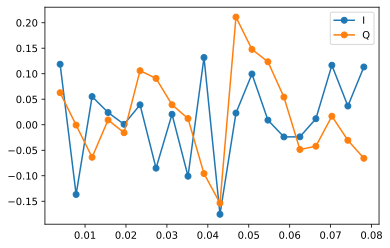

In [4]:
plt.plot(times[1:], dMs[:, 0], 'o-', label='I')
plt.plot(times[1:], dMs[:, 1], 'o-', label='Q')
plt.legend()
plt.show()

### Verify that dMs = sqrt(2)*dWs + L_Ldag[1:] * dt , since the dW\_factor = 1/sqrt(2)

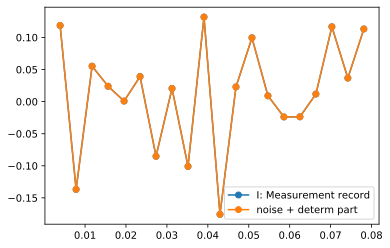

In [5]:
plt.plot(times[1:], dMs[:, 0], 'o-', label='I: Measurement record')
plt.plot(times[1:], np.sqrt(2)*dWs[:, 0] + L_Ldag[1:] * dt, 'o-', label='noise + determ part')
plt.legend()
plt.show()

In [6]:
dMs[:, 0] == np.sqrt(2)*dWs[:, 0] + L_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### It works for the I quadrature, let's repeat for the Q quadrature

In [7]:
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + iL_Ldag[1:] * dt

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

### Of course, it does not work since the specified m\_ops is -1j\*c-c.dag().
### Let's verify that the Q quadrature is consistent with the wrong measurement operator.

In [8]:
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + np.real(wrong_iL_Ldag[1:]) * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### Great, then we just need to change the second m\_ops to represent the actual the orthogonal quadratures that can be measured in an experiment. This is what is done in the pull request #1237.

### Verify that the same is true for the rouchon solver, which uses a different scheme (_positive_map)

In [9]:
solver='rouchon'

result_rouchon = qutip.smesolve(H, rho_0, times,
                                 sc_ops=[L], 
                                 e_ops=[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz(), 
                                        L+L.dag(), -1j*(L-L.dag()), -1j*L-L.dag()], # Extract complete info
                                 method='heterodyne', solver=solver, store_measurement=True, 
                                 noise=seed)

# dMs = sqrt(2)*dWs + L_Ldag[1:] * dt  is our correspondance here with the correct slicing.
dWs = result_rouchon.noise[0, :-1, 0, :]

L_Ldag = result_rouchon.expect[4][:]
iL_Ldag = result_rouchon.expect[5][:]
wrong_iL_Ldag = result_rouchon.expect[6][:]

dMs = np.real(result_rouchon.measurement[0])[:-1,0,:] * dt 
            
# [<I>=Tr{\rho}, <X>, <Y>, <Z>]
smetraj_rouchon = np.array([result_rouchon.expect[0][:], result_rouchon.expect[1][:], 
                            result_rouchon.expect[2][:], result_rouchon.expect[3][:]]) 

Total run time:   0.00s


In [10]:
# I quadrature
dMs[:, 0] == np.sqrt(2)*dWs[:, 0] + L_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [11]:
# True Q quadrature
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + iL_Ldag[1:] * dt

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [12]:
# Known wrong Q quadrature
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + np.real(wrong_iL_Ldag[1:]) * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

# Part 2: Verify that the pull request #1237 fixes this problem accurately.

Copy code of stochastic.py and change lines 613 and 790 for the true m_ops.

In [13]:
# -*- coding: utf-8 -*-
#
# This file is part of QuTiP: Quantum Toolbox in Python.
#
#    Copyright (c) 2011 and later, Paul D. Nation and Robert J. Johansson.
#    All rights reserved.
#
#    Redistribution and use in source and binary forms, with or without
#    modification, are permitted provided that the following conditions are
#    met:
#
#    1. Redistributions of source code must retain the above copyright notice,
#       this list of conditions and the following disclaimer.
#
#    2. Redistributions in binary form must reproduce the above copyright
#       notice, this list of conditions and the following disclaimer in the
#       documentation and/or other materials provided with the distribution.
#
#    3. Neither the name of the QuTiP: Quantum Toolbox in Python nor the names
#       of its contributors may be used to endorse or promote products derived
#       from this software without specific prior written permission.
#
#    THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
#    "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
#    LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A
#    PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
#    HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
#    SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
#    LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
#    DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
#    THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
#    (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
#    OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
###############################################################################
import numpy as np
import scipy.sparse as sp
from qutip.cy.stochastic import (SSESolver, SMESolver, PcSSESolver, PcSMESolver,
                                 PmSMESolver, GenericSSolver, Solvers)
from qutip.qobj import Qobj, isket, isoper, issuper
from qutip.states import ket2dm
from qutip.solver import Result
from qutip.qobjevo import QobjEvo
from qutip.superoperator import (spre, spost, mat2vec, vec2mat,
                                 liouvillian, lindblad_dissipator)
from qutip.solver import Options, _solver_safety_check
from qutip.parallel import serial_map
from qutip.ui.progressbar import TextProgressBar
from qutip.pdpsolve import main_ssepdpsolve, main_smepdpsolve

__all__ = ['ssesolve', 'photocurrent_sesolve', 'smepdpsolve',
           'smesolve', 'photocurrent_mesolve', 'ssepdpsolve',
           'stochastic_solvers', 'general_stochastic']


def stochastic_solvers():
    """Available solvers for ssesolve and smesolve
    euler-maruyama:
        A simple generalization of the Euler method for ordinary
        differential equations to stochastic differential equations.
        Only solver which could take non-commuting sc_ops. *not tested*
        -Order 0.5
        -Code: 'euler-maruyama', 'euler', 0.5

    milstein, Order 1.0 strong Taylor scheme:
        Better approximate numerical solution to stochastic
        differential equations.
        -Order strong 1.0
        -Code: 'milstein', 1.0
        Numerical Solution of Stochastic Differential Equations
        Chapter 10.3 Eq. (3.1), By Peter E. Kloeden, Eckhard Platen

    milstein-imp, Order 1.0 implicit strong Taylor scheme:
        Implicit milstein scheme for the numerical simulation of stiff
        stochastic differential equations.
        -Order strong 1.0
        -Code: 'milstein-imp'
        Numerical Solution of Stochastic Differential Equations
        Chapter 12.2 Eq. (2.9), By Peter E. Kloeden, Eckhard Platen

    predictor-corrector:
        Generalization of the trapezoidal method to stochastic
        differential equations. More stable than explicit methods.
        -Order strong 0.5, weak 1.0
        Only the stochastic part is corrected.
            (alpha = 0, eta = 1/2)
            -Code: 'pred-corr', 'predictor-corrector', 'pc-euler'
        Both the deterministic and stochastic part corrected.
            (alpha = 1/2, eta = 1/2)
            -Code: 'pc-euler-imp', 'pc-euler-2', 'pred-corr-2'
        Numerical Solution of Stochastic Differential Equations
        Chapter 15.5 Eq. (5.4), By Peter E. Kloeden, Eckhard Platen

    platen:
        Explicit scheme, create the milstein using finite difference instead of
        derivatives. Also contain some higher order terms, thus converge better
        than milstein while staying strong order 1.0.
        Do not require derivatives, therefore usable for
        :func:`qutip.stochastic.general_stochastic`
        -Order strong 1.0, weak 2.0
        -Code: 'platen', 'platen1', 'explicit1'
        The Theory of Open Quantum Systems
        Chapter 7 Eq. (7.47), H.-P Breuer, F. Petruccione

    rouchon:
        Scheme keeping the positivity of the density matrix. (smesolve only)
        -Order strong 1.0?
        -Code: 'rouchon', 'Rouchon'
        Eq. 4 of arXiv:1410.5345 with eta=1
        Efficient Quantum Filtering for Quantum Feedback Control
        Pierre Rouchon, Jason F. Ralph
        arXiv:1410.5345 [quant-ph]
        Phys. Rev. A 91, 012118, (2015)

    taylor1.5, Order 1.5 strong Taylor scheme:
        Solver with more terms of the Ito-Taylor expansion.
        Default solver for smesolve and ssesolve.
        -Order strong 1.5
        -Code: 'taylor1.5', 'taylor15', 1.5, None
        Numerical Solution of Stochastic Differential Equations
        Chapter 10.4 Eq. (4.6), By Peter E. Kloeden, Eckhard Platen

    taylor1.5-imp, Order 1.5 implicit strong Taylor scheme:
        implicit Taylor 1.5 (alpha = 1/2, beta = doesn't matter)
        -Order strong 1.5
        -Code: 'taylor1.5-imp', 'taylor15-imp'
        Numerical Solution of Stochastic Differential Equations
        Chapter 12.2 Eq. (2.18), By Peter E. Kloeden, Eckhard Platen

    explicit1.5, Explicit Order 1.5 Strong Schemes:
        Reproduce the order 1.5 strong Taylor scheme using finite difference
        instead of derivatives. Slower than taylor15 but usable by
        :func:`qutip.stochastic.general_stochastic`
        -Order strong 1.5
        -Code: 'explicit1.5', 'explicit15', 'platen15'
        Numerical Solution of Stochastic Differential Equations
        Chapter 11.2 Eq. (2.13), By Peter E. Kloeden, Eckhard Platen

    taylor2.0, Order 2 strong Taylor scheme:
        Solver with more terms of the Stratonovich expansion.
        -Order strong 2.0
        -Code: 'taylor2.0', 'taylor20', 2.0
        Numerical Solution of Stochastic Differential Equations
        Chapter 10.5 Eq. (5.2), By Peter E. Kloeden, Eckhard Platen

    ---All solvers, except taylor2.0, are usable in both smesolve and ssesolve
    and for both heterodyne and homodyne. taylor2.0 only work for 1 stochastic
    operator not dependent of time with the homodyne method.
    The :func:`qutip.stochastic.general_stochastic` only accept derivatives
    free solvers: ['euler', 'platen', 'explicit1.5'].

Available solver for photocurrent_sesolve and photocurrent_mesolve:
        Photocurrent use ordinary differential equations between
        stochastic "jump/collapse".
    euler:
        Euler method for ordinary differential equations between jumps.
        Only 1 jumps per time interval.
        Default solver
        -Order 1.0
        -Code: 'euler'
        Quantum measurement and control
        Chapter 4, Eq 4.19, 4.40, By Howard M. Wiseman, Gerard J. Milburn

    predictor–corrector:
        predictor–corrector method (PECE) for ordinary differential equations.
        Use poisson distribution to obtain the number of jump at each timestep.
        -Order 2.0
        -Code: 'pred-corr'

    """
    pass


class StochasticSolverOptions:
    """Class of options for stochastic solvers such as
    :func:`qutip.stochastic.ssesolve`, :func:`qutip.stochastic.smesolve`, etc.

    The stochastic solvers :func:`qutip.stochastic.general_stochastic`,
    :func:`qutip.stochastic.ssesolve`, :func:`qutip.stochastic.smesolve`,
    :func:`qutip.stochastic.photocurrent_sesolve` and
    :func:`qutip.stochastic.photocurrent_mesolve`
    all take the same keyword arguments as
    the constructor of these class, and internally they use these arguments to
    construct an instance of this class, so it is rarely needed to explicitly
    create an instance of this class.

    Attributes
    ----------

    H : :class:`qutip.Qobj`, time-dependent Qobj as a list*
        System Hamiltonian.

    state0 : :class:`qutip.Qobj`
        Initial state vector (ket) or density matrix.

    times : *list* / *array*
        List of times for :math:`t`. Must be uniformly spaced.

    c_ops : list of :class:`qutip.Qobj`, :class:`qutip.QobjEvo` or [Qobj, coeff*]
        List of deterministic collapse operators.

    sc_ops : list of :class:`qutip.Qobj`, :class:`qutip.QobjEvo` or [Qobj, coeff*]
        List of stochastic collapse operators. Each stochastic collapse
        operator will give a deterministic and stochastic contribution
        to the equation of motion according to how the d1 and d2 functions
        are defined.

    e_ops : list of :class:`qutip.Qobj`
        Single operator or list of operators for which to evaluate
        expectation values.

    m_ops : list of :class:`qutip.Qobj`
        List of operators representing the measurement operators. The expected
        format is a nested list with one measurement operator for each
        stochastic increament, for each stochastic collapse operator.

    args : dict
        Dictionary of parameters for time dependent systems.

    tol : float
        Tolerance of the solver for implicit methods.

    ntraj : int
        Number of trajectors.

    nsubsteps : int
        Number of sub steps between each time-spep given in `times`.

    dW_factors : array
        Array of length len(sc_ops), containing scaling factors for each
        measurement operator in m_ops.

    solver : string
        Name of the solver method to use for solving the stochastic
        equations. Valid values are:
        order 1/2 algorithms: 'euler-maruyama', 'pc-euler', 'pc-euler-imp'
        order 1 algorithms: 'milstein', 'platen', 'milstein-imp', 'rouchon'
        order 3/2 algorithms: 'taylor1.5', 'taylor1.5-imp', 'explicit1.5'
        order 2 algorithms: 'taylor2.0'
        call help of :func:`qutip.stochastic.stochastic_solvers`
        for a description of the solvers.
        Implicit methods can adjust tolerance via the kw 'tol'
        default is {'tol':1e-6}

    method : string ('homodyne', 'heterodyne')
        The name of the type of measurement process that give rise to the
        stochastic equation to solve.

    store_all_expect : bool (default False)
        Whether or not to store the e_ops expect values for all paths.

    store_measurement : bool (default False)
        Whether or not to store the measurement results in the
        :class:`qutip.solver.Result` instance returned by the solver.

    noise : int, array[int, 1d], array[double, 4d]
        int : seed of the noise
        array[int, 1d], length = ntraj, seeds for each trajectories
        array[double, 4d] (ntraj, len(times), nsubsteps, len(sc_ops)*[1|2])
            vector for the noise, the len of the last dimensions is doubled for
            solvers of order 1.5. The correspond to results.noise

    noiseDepth : int
        Number of terms kept of the truncated series used to create the
        noise used by taylor2.0 solver.

    normalize : bool
        (default True for (photo)ssesolve, False for (photo)smesolve)
        Whether or not to normalize the wave function during the evolution.
        Normalizing density matrices introduce numerical errors.

    options : :class:`qutip.solver.Options`
        Generic solver options. Only options.average_states and
        options.store_states are used.

    map_func: function
        A map function or managing the calls to single-trajactory solvers.

    map_kwargs: dictionary
        Optional keyword arguments to the map_func function function.

    progress_bar : :class:`qutip.ui.BaseProgressBar`
        Optional progress bar class instance.

    *
    time-dependent Qobj can be used for H, c_ops and sc_ops.
    The format for time-dependent system hamiltonian is:
    H = [Qobj0,[Qobj1,coeff1],[Qobj2,coeff2],...]
      = Qobj0 + Qobj1 * coeff1(t) + Qobj2 * coeff2(t)

    coeff function can be:
        function: coeff(t, args) -> complex
        str: "sin(1j*w*t)"
        np.array[complex, 1d] of length equal to the times array
    The argument args for the function coeff is the args keyword argument of
        the stochastic solver.
    Likewisem in str cases, the parameters ('w' in this case) are taken from
        the args keywords argument.
    *While mixing coeff type does not results in errors, it is not recommended.*

    For the collapse operators (c_ops, sc_ops):
    Each operators can only be composed of 1 Qobj.
    c_ops = [c_op1, c_op2, ...]
    where, c_opN = Qobj or [Qobj,coeff]
    The coeff format is the same as for the Hamiltonian.
    """
    def __init__(self, me, H=None, c_ops=[], sc_ops=[], state0=None,
                 e_ops=[], m_ops=None, store_all_expect=False,
                 store_measurement=False, dW_factors=None,
                 solver=None, method="homodyne", normalize=None,
                 times=None, nsubsteps=1, ntraj=1, tol=None,
                 generate_noise=None, noise=None,
                 progress_bar=None, map_func=None, map_kwargs=None,
                 args={}, options=None, noiseDepth=20):

        if options is None:
            options = Options()

        if progress_bar is None:
            progress_bar = TextProgressBar()

        # System
        # Cast to QobjEvo so the code has only one version for both the
        # constant and time-dependent case.
        self.me = me
        if H is not None:
            try:
                self.H = QobjEvo(H, args=args, tlist=times)
            except:
                raise Exception("The hamiltonian format is not valid")
        else:
            self.H = H

        if sc_ops:
            try:
                self.sc_ops = [QobjEvo(op, args=args, tlist=times)
                               for op in sc_ops]
            except:
                raise Exception("The sc_ops format is not valid.\n" +
                                "[ Qobj / QobjEvo / [Qobj,coeff]]")
        else:
            self.sc_ops = sc_ops

        if c_ops:
            try:
                self.c_ops = [QobjEvo(op, args=args, tlist=times)
                              for op in c_ops]
            except:
                raise Exception("The c_ops format is not valid.\n" +
                                "[ Qobj / QobjEvo / [Qobj,coeff]]")
        else:
            self.c_ops = c_ops

        self.state0 = state0
        self.rho0 = mat2vec(state0.full()).ravel()

        # Observation
        self.e_ops = e_ops
        self.m_ops = m_ops
        self.store_measurement = store_measurement
        self.store_all_expect = store_all_expect
        self.store_states = options.store_states
        self.dW_factors = dW_factors

        # Solver
        self.solver = solver
        self.method = method
        if normalize is None and me:
            self.normalize = 0
        elif normalize is None and not me:
            self.normalize = 1
        elif normalize:
            self.normalize = 1
        else:
            self.normalize = 0

        self.times = times
        self.nsubsteps = nsubsteps
        self.dt = (times[1] - times[0]) / self.nsubsteps
        self.ntraj = ntraj
        if tol is not None:
            self.tol = tol
        elif "tol" in args:
            self.tol = args["tol"]
        else:
            self.tol = 1e-7

        # Noise
        if noise is not None:
            if isinstance(noise, int):
                # noise contain a seed
                np.random.seed(noise)
                noise = np.random.randint(0, 2**32, ntraj)
            noise = np.array(noise)
            if len(noise.shape) == 1:
                if noise.shape[0] < ntraj:
                    raise Exception("'noise' does not have enought seeds" +
                                    "len(noise) >= ntraj")
                # numpy seed must be between 0 and 2**32-1
                # 'u4': unsigned 32bit int
                self.noise = noise.astype("u4")
                self.noise_type = 0

            elif len(noise.shape) == 4:
                # taylor case not included
                dw_len = (2 if method == "heterodyne" else 1)
                dw_len_str = (" * 2" if method == "heterodyne" else "")
                if noise.shape[0] < ntraj:
                    raise Exception("'noise' does not have the right shape" +
                                    "shape[0] >= ntraj")
                if noise.shape[1] < len(times):
                    raise Exception("'noise' does not have the right shape" +
                                    "shape[1] >= len(times)")
                if noise.shape[2] < nsubsteps:
                    raise Exception("'noise' does not have the right shape" +
                                    "shape[2] >= nsubsteps")
                if noise.shape[3] < len(self.sc_ops) * dw_len:
                    raise Exception("'noise' does not have the right shape: " +
                                    "shape[3] >= len(self.sc_ops)" +
                                    dw_len_str)
                self.noise_type = 1
                self.noise = noise

        else:
            self.noise = np.random.randint(0, 2**32, ntraj).astype("u4")
            self.noise_type = 0

        # Map
        self.progress_bar = progress_bar
        if self.ntraj > 1 and map_func:
            self.map_func = map_func
        else:
            self.map_func = serial_map
        self.map_kwargs = map_kwargs if map_kwargs is not None else {}

        # Other
        self.options = options
        self.args = args
        self.set_solver()
        self.p = noiseDepth

    def set_solver(self):
        if self.solver in ['euler-maruyama', 'euler', 50, 0.5]:
            self.solver_code = 50
            self.solver = 'euler-maruyama'
        elif self.solver in ['platen', 'platen1', 'explicit1', 100]:
            self.solver_code = 100
            self.solver = 'platen'
        elif self.solver in ['pred-corr', 'predictor-corrector',
                             'pc-euler', 101]:
            self.solver_code = 101
            self.solver = 'pred-corr'
        elif self.solver in ['milstein', 102, 1.0]:
            self.solver_code = 102
            self.solver = 'milstein'
        elif self.solver in ['milstein-imp', 103]:
            self.solver_code = 103
            self.solver = 'milstein-imp'
        elif self.solver in ['pred-corr-2', 'pc-euler-2', 'pc-euler-imp', 104]:
            self.solver_code = 104
            self.solver = 'pred-corr-2'
        elif self.solver in ['Rouchon', 'rouchon', 120]:
            self.solver_code = 120
            self.solver = 'rouchon'
            if not all((op.const for op in self.sc_ops)):
                raise Exception("Rouchon only work with constant sc_ops")
        elif self.solver in ['platen15', 'explicit1.5', 'explicit15', 150]:
            self.solver_code = 150
            self.solver = 'explicit1.5'
        elif self.solver in ['taylor15', 'taylor1.5', None, 1.5, 152]:
            self.solver_code = 152
            self.solver = 'taylor1.5'
        elif self.solver in ['taylor15-imp', 'taylor1.5-imp', 153]:
            self.solver_code = 153
            self.solver = 'taylor1.5-imp'
        elif self.solver in ['taylor2.0', 'taylor20', 2.0, 202]:
            self.solver_code = 202
            self.solver = 'taylor2.0'
            if not len(self.sc_ops) == 1 or \
                    not self.sc_ops[0].const or \
                    not self.method == "homodyne":
                raise Exception("Taylor2.0 only work with 1 constant sc_ops " +
                                "and for homodyne method")
        else:
            raise Exception("The solver should be one of " +
                            "[None, 'euler-maruyama', 'platen', 'pc-euler', " +
                            "'pc-euler-imp', 'milstein', 'milstein-imp', " +
                            "'rouchon', " +
                            "'taylor1.5', 'taylor1.5-imp', 'explicit1.5' " +
                            "'taylor2.0']")


class StochasticSolverOptionsPhoto(StochasticSolverOptions):
    """
    Attributes
    ----------

    solver : string
        Name of the solver method to use for solving the evolution
        of the system.*
        order 1 algorithms: 'euler'
        order 2 algorithms: 'pred-corr'
        In photocurrent evolution
    """
    def set_solver(self):
        if self.solver in [None, 'euler', 1, 60]:
            self.solver_code = 60
            self.solver = 'euler'
        elif self.solver in ['pred-corr', 'predictor-corrector', 110, 2]:
            self.solver_code = 110
            self.solver = 'pred-corr'
        else:
            raise Exception("The solver should be one of " +
                            "[None, 'euler', 'predictor-corrector']")


def smesolve(H, rho0, times, c_ops=[], sc_ops=[], e_ops=[],
             _safe_mode=True, args={}, **kwargs):
    """
    Solve stochastic master equation. Dispatch to specific solvers
    depending on the value of the `solver` keyword argument.

    Parameters
    ----------

    H : :class:`qutip.Qobj`, or time dependent system.
        System Hamiltonian.
        Can depend on time, see StochasticSolverOptions help for format.

    rho0 : :class:`qutip.Qobj`
        Initial density matrix or state vector (ket).

    times : *list* / *array*
        List of times for :math:`t`. Must be uniformly spaced.

    c_ops : list of :class:`qutip.Qobj`, or time dependent Qobjs.
        Deterministic collapse operator which will contribute with a standard
        Lindblad type of dissipation.
        Can depend on time, see StochasticSolverOptions help for format.

    sc_ops : list of :class:`qutip.Qobj`, or time dependent Qobjs.
        List of stochastic collapse operators. Each stochastic collapse
        operator will give a deterministic and stochastic contribution
        to the eqaution of motion according to how the d1 and d2 functions
        are defined.
        Can depend on time, see StochasticSolverOptions help for format.

    e_ops : list of :class:`qutip.Qobj`
        single operator or list of operators for which to evaluate
        expectation values.

    kwargs : *dictionary*
        Optional keyword arguments. See
        :class:`qutip.stochastic.StochasticSolverOptions`.

    Returns
    -------

    output: :class:`qutip.solver.Result`

        An instance of the class :class:`qutip.solver.Result`.

    """
    if "method" in kwargs and kwargs["method"] == "photocurrent":
        print("stochastic solver with photocurrent method has been moved to "
              "it's own function: photocurrent_mesolve")
        return photocurrent_mesolve(H, rho0, times, c_ops=c_ops, sc_ops=sc_ops,
                                   e_ops=e_ops, _safe_mode=_safe_mode,
                                   args=args, **kwargs)
    if isket(rho0):
        rho0 = ket2dm(rho0)

    if isinstance(e_ops, dict):
        e_ops_dict = e_ops
        e_ops = [e for e in e_ops.values()]
    else:
        e_ops_dict = None

    sso = StochasticSolverOptions(True, H=H, state0=rho0, times=times,
                                  c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops,
                                  args=args, **kwargs)

    if _safe_mode:
        _safety_checks(sso)

    if sso.solver_code == 120:
        return _positive_map(sso, e_ops_dict)

    sso.LH = liouvillian(sso.H, c_ops=sso.sc_ops + sso.c_ops) * sso.dt
    if sso.method == 'homodyne' or sso.method is None:
        if sso.m_ops is None:
            sso.m_ops = [op + op.dag() for op in sso.sc_ops]
        sso.sops = [spre(op) + spost(op.dag()) for op in sso.sc_ops]
        if not isinstance(sso.dW_factors, list):
            sso.dW_factors = [1] * len(sso.m_ops)
        elif len(sso.dW_factors) != len(sso.m_ops):
            raise Exception("The len of dW_factors is not the same as m_ops")

    elif sso.method == 'heterodyne':
        if sso.m_ops is None:
            m_ops = []
        sso.sops = []
        for c in sso.sc_ops:
            if sso.m_ops is None:
                m_ops += [c + c.dag(), -1j * (c - c.dag())]
            sso.sops += [(spre(c) + spost(c.dag())) / np.sqrt(2),
                         (spre(c) - spost(c.dag())) * -1j / np.sqrt(2)]
        sso.m_ops = m_ops
        if not isinstance(sso.dW_factors, list):
            sso.dW_factors = [np.sqrt(2)] * len(sso.sops)
        elif len(sso.dW_factors) == len(sso.m_ops):
            pass
        elif len(sso.dW_factors) == len(sso.sc_ops):
            dW_factors = []
            for fact in sso.dW_factors:
                dW_factors += [np.sqrt(2) * fact, np.sqrt(2) * fact]
            sso.dW_factors = dW_factors
        elif len(sso.dW_factors) != len(sso.m_ops):
            raise Exception("The len of dW_factors is not the same as sc_ops")

    elif sso.method == "photocurrent":
        raise NotImplementedError("Moved to 'photocurrent_mesolve'")

    else:
        raise Exception("The method must be one of None, homodyne, heterodyne")

    sso.ce_ops = [QobjEvo(spre(op)) for op in sso.e_ops]
    sso.cm_ops = [QobjEvo(spre(op)) for op in sso.m_ops]

    sso.LH.compile()
    [op.compile() for op in sso.sops]
    [op.compile() for op in sso.cm_ops]
    [op.compile() for op in sso.ce_ops]

    if sso.solver_code in [103, 153]:
        sso.imp = 1 - sso.LH * 0.5
        sso.imp.compile()

    sso.solver_obj = SMESolver
    sso.solver_name = "smesolve_" + sso.solver

    res = _sesolve_generic(sso, sso.options, sso.progress_bar)

    if e_ops_dict:
        res.expect = {e: res.expect[n]
                      for n, e in enumerate(e_ops_dict.keys())}
    return res


def ssesolve(H, psi0, times, sc_ops=[], e_ops=[],
             _safe_mode=True, args={}, **kwargs):
    """
    Solve stochastic schrodinger equation. Dispatch to specific solvers
    depending on the value of the `solver` keyword argument.

    Parameters
    ----------

    H : :class:`qutip.Qobj`, or time dependent system.
        System Hamiltonian.
        Can depend on time, see StochasticSolverOptions help for format.

    psi0 : :class:`qutip.Qobj`
        State vector (ket).

    times : *list* / *array*
        List of times for :math:`t`. Must be uniformly spaced.

    sc_ops : list of :class:`qutip.Qobj`, or time dependent Qobjs.
        List of stochastic collapse operators. Each stochastic collapse
        operator will give a deterministic and stochastic contribution
        to the eqaution of motion according to how the d1 and d2 functions
        are defined.
        Can depend on time, see StochasticSolverOptions help for format.

    e_ops : list of :class:`qutip.Qobj`
        single operator or list of operators for which to evaluate
        expectation values.

    kwargs : *dictionary*
        Optional keyword arguments. See
        :class:`qutip.stochastic.StochasticSolverOptions`.

    Returns
    -------

    output: :class:`qutip.solver.Result`

        An instance of the class :class:`qutip.solver.Result`.
    """
    if "method" in kwargs and kwargs["method"] == "photocurrent":
        print("stochastic solver with photocurrent method has been moved to "
              "it's own function: photocurrent_sesolve")
        return photocurrent_sesolve(H, psi0, times, c_ops=c_ops,
                                   e_ops=e_ops, _safe_mode=_safe_mode,
                                   args=args, **kwargs)

    if isinstance(e_ops, dict):
        e_ops_dict = e_ops
        e_ops = [e for e in e_ops.values()]
    else:
        e_ops_dict = None

    sso = StochasticSolverOptions(False, H=H, state0=psi0, times=times,
                                  sc_ops=sc_ops, e_ops=e_ops,
                                  args=args, **kwargs)

    if _safe_mode:
        _safety_checks(sso)

    if sso.solver_code == 120:
        raise Exception("rouchon only work with smesolve")

    if sso.method == 'homodyne' or sso.method is None:
        if sso.m_ops is None:
            sso.m_ops = [op + op.dag() for op in sso.sc_ops]
        sso.sops = [[op, op + op.dag()] for op in sso.sc_ops]
        if not isinstance(sso.dW_factors, list):
            sso.dW_factors = [1] * len(sso.sops)
        elif len(sso.dW_factors) != len(sso.sops):
            raise Exception("The len of dW_factors is not the same as sc_ops")

    elif sso.method == 'heterodyne':
        if sso.m_ops is None:
            m_ops = []
        sso.sops = []
        for c in sso.sc_ops:
            if sso.m_ops is None:
                m_ops += [c + c.dag(), -1j * (c - c.dag())]
            c1 = c / np.sqrt(2)
            c2 = c * (-1j / np.sqrt(2))
            sso.sops += [[c1, c1 + c1.dag()],
                         [c2, c2 + c2.dag()]]
        sso.m_ops = m_ops
        if not isinstance(sso.dW_factors, list):
            sso.dW_factors = [np.sqrt(2)] * len(sso.sops)
        elif len(sso.dW_factors) == len(sso.sc_ops):
            dW_factors = []
            for fact in sso.dW_factors:
                dW_factors += [np.sqrt(2) * fact, np.sqrt(2) * fact]
            sso.dW_factors = dW_factors
        elif len(sso.dW_factors) != len(sso.sops):
            raise Exception("The len of dW_factors is not the same as sc_ops")

    elif sso.method == "photocurrent":
        NotImplementedError("Moved to 'photocurrent_sesolve'")

    else:
        raise Exception("The method must be one of None, homodyne, heterodyne")

    sso.LH = sso.H * (-1j*sso.dt)
    for ops in sso.sops:
        sso.LH -= ops[0]._cdc()*0.5*sso.dt

    sso.ce_ops = [QobjEvo(op) for op in sso.e_ops]
    sso.cm_ops = [QobjEvo(op) for op in sso.m_ops]

    sso.LH.compile()
    [[op.compile() for op in ops] for ops in sso.sops]
    [op.compile() for op in sso.cm_ops]
    [op.compile() for op in sso.ce_ops]

    sso.solver_obj = SSESolver
    sso.solver_name = "ssesolve_" + sso.solver

    res = _sesolve_generic(sso, sso.options, sso.progress_bar)

    if e_ops_dict:
        res.expect = {e: res.expect[n]
                      for n, e in enumerate(e_ops_dict.keys())}

    return res


def _positive_map(sso, e_ops_dict):
    if sso.method == 'homodyne' or sso.method is None:
        sops = sso.sc_ops
        if sso.m_ops is None:
            sso.m_ops = [op + op.dag() for op in sso.sc_ops]
        if not isinstance(sso.dW_factors, list):
            sso.dW_factors = [1] * len(sops)
        elif len(sso.dW_factors) != len(sops):
            raise Exception("The len of dW_factors is not the same as sc_ops")

    elif sso.method == 'heterodyne':
        if sso.m_ops is None:
            m_ops = []
        sops = []
        for c in sso.sc_ops:
            if sso.m_ops is None:
                m_ops += [c + c.dag(), -1j * (c - c.dag())]
            sops += [c / np.sqrt(2), -1j / np.sqrt(2) * c]
        sso.m_ops = m_ops
        if not isinstance(sso.dW_factors, list):
            sso.dW_factors = [np.sqrt(2)] * len(sops)
        elif len(sso.dW_factors) == len(sso.sc_ops):
            dW_factors = []
            for fact in sso.dW_factors:
                dW_factors += [np.sqrt(2) * fact, np.sqrt(2) * fact]
            sso.dW_factors = dW_factors
        elif len(sso.dW_factors) != len(sops):
            raise Exception("The len of dW_factors is not the same as sc_ops")
    else:
        raise Exception("The method must be one of homodyne or heterodyne")

    LH = 1 - (sso.H * 1j * sso.dt)
    sso.pp = spre(sso.H) * 0
    sso.sops = []
    sso.preops = []
    sso.postops = []
    sso.preops2 = []
    sso.postops2 = []

    def _prespostdag(op):
        return spre(op) * spost(op.dag())

    for op in sso.c_ops:
        LH -= op._cdc() * sso.dt * 0.5
        sso.pp += op.apply(_prespostdag)._f_norm2() * sso.dt

    for i, op in enumerate(sops):
        LH -= op._cdc() * sso.dt * 0.5
        sso.sops += [(spre(op) + spost(op.dag())) * sso.dt]
        sso.preops += [spre(op)]
        sso.postops += [spost(op.dag())]
        for op2 in sops[i:]:
            sso.preops2 += [spre(op * op2)]
            sso.postops2 += [spost(op.dag() * op2.dag())]

    sso.ce_ops = [QobjEvo(spre(op)) for op in sso.e_ops]
    sso.cm_ops = [QobjEvo(spre(op)) for op in sso.m_ops]
    sso.preLH = spre(LH)
    sso.postLH = spost(LH.dag())
    sso.preLH.compile()
    sso.postLH.compile()
    sso.pp.compile()
    [op.compile() for op in sso.sops]
    [op.compile() for op in sso.preops]
    [op.compile() for op in sso.postops]
    [op.compile() for op in sso.preops2]
    [op.compile() for op in sso.postops2]
    [op.compile() for op in sso.cm_ops]
    [op.compile() for op in sso.ce_ops]

    sso.solver_obj = PmSMESolver
    sso.solver_name = "smesolve_" + sso.solver
    res = _sesolve_generic(sso, sso.options, sso.progress_bar)

    if e_ops_dict:
        res.expect = {e: res.expect[n]
                      for n, e in enumerate(e_ops_dict.keys())}

    return res


def photocurrent_mesolve(H, rho0, times, c_ops=[], sc_ops=[], e_ops=[],
                        _safe_mode=True, args={}, **kwargs):
    """
    Solve stochastic master equation using the photocurrent method.

    Parameters
    ----------

    H : :class:`qutip.Qobj`, or time dependent system.
        System Hamiltonian.
        Can depend on time, see StochasticSolverOptions help for format.

    rho0 : :class:`qutip.Qobj`
        Initial density matrix or state vector (ket).

    times : *list* / *array*
        List of times for :math:`t`. Must be uniformly spaced.

    c_ops : list of :class:`qutip.Qobj`, or time dependent Qobjs.
        Deterministic collapse operator which will contribute with a standard
        Lindblad type of dissipation.
        Can depend on time, see StochasticSolverOptions help for format.

    sc_ops : list of :class:`qutip.Qobj`, or time dependent Qobjs.
        List of stochastic collapse operators. Each stochastic collapse
        operator will give a deterministic and stochastic contribution
        to the eqaution of motion according to how the d1 and d2 functions
        are defined.
        Can depend on time, see StochasticSolverOptions help for format.

    e_ops : list of :class:`qutip.Qobj` / callback function single
        single operator or list of operators for which to evaluate
        expectation values.

    kwargs : *dictionary*
        Optional keyword arguments. See
        :class:`qutip.stochastic.StochasticSolverOptions`.

    Returns
    -------

    output: :class:`qutip.solver.Result`

        An instance of the class :class:`qutip.solver.Result`.
    """
    if isket(rho0):
        rho0 = ket2dm(rho0)

    if isinstance(e_ops, dict):
        e_ops_dict = e_ops
        e_ops = [e for e in e_ops.values()]
    else:
        e_ops_dict = None

    sso = StochasticSolverOptionsPhoto(True, H=H, state0=rho0, times=times,
                                       c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops,
                                       args=args, **kwargs)

    if _safe_mode:
        _safety_checks(sso)

    if sso.m_ops is None:
        sso.m_ops = [op * 0 for op in sso.sc_ops]
    if not isinstance(sso.dW_factors, list):
        sso.dW_factors = [1] * len(sso.sc_ops)
    elif len(sso.dW_factors) != len(sso.sc_ops):
        raise Exception("The len of dW_factors is not the same as sc_ops")

    sso.solver_obj = PcSMESolver
    sso.solver_name = "photocurrent_mesolve"
    sso.LH = liouvillian(sso.H, c_ops=sso.c_ops) * sso.dt

    def _prespostdag(op):
        return spre(op) * spost(op.dag())

    sso.sops = [[spre(op._cdc()) + spost(op._cdc()),
                 spre(op._cdc()),
                 op.apply(_prespostdag)._f_norm2()] for op in sso.sc_ops]
    sso.ce_ops = [QobjEvo(spre(op)) for op in sso.e_ops]
    sso.cm_ops = [QobjEvo(spre(op)) for op in sso.m_ops]

    sso.LH.compile()
    [[op.compile() for op in ops] for ops in sso.sops]
    [op.compile() for op in sso.cm_ops]
    [op.compile() for op in sso.ce_ops]

    res = _sesolve_generic(sso, sso.options, sso.progress_bar)
    res.num_collapse = [np.count_nonzero(noise) for noise in res.noise]

    if e_ops_dict:
        res.expect = {e: res.expect[n]
                      for n, e in enumerate(e_ops_dict.keys())}

    return res


def photocurrent_sesolve(H, psi0, times, sc_ops=[], e_ops=[],
                        _safe_mode=True, args={}, **kwargs):
    """
    Solve stochastic schrodinger equation using the photocurrent method.

    Parameters
    ----------

    H : :class:`qutip.Qobj`, or time dependent system.
        System Hamiltonian.
        Can depend on time, see StochasticSolverOptions help for format.

    psi0 : :class:`qutip.Qobj`
        Initial state vector (ket).

    times : *list* / *array*
        List of times for :math:`t`. Must be uniformly spaced.

    sc_ops : list of :class:`qutip.Qobj`, or time dependent Qobjs.
        List of stochastic collapse operators. Each stochastic collapse
        operator will give a deterministic and stochastic contribution
        to the eqaution of motion according to how the d1 and d2 functions
        are defined.
        Can depend on time, see StochasticSolverOptions help for format.

    e_ops : list of :class:`qutip.Qobj` / callback function single
        single operator or list of operators for which to evaluate
        expectation values.

    kwargs : *dictionary*
        Optional keyword arguments. See
        :class:`qutip.stochastic.StochasticSolverOptions`.

    Returns
    -------

    output: :class:`qutip.solver.Result`

        An instance of the class :class:`qutip.solver.Result`.
    """
    if isinstance(e_ops, dict):
        e_ops_dict = e_ops
        e_ops = [e for e in e_ops.values()]
    else:
        e_ops_dict = None

    sso = StochasticSolverOptionsPhoto(False, H=H, state0=psi0, times=times,
                                       sc_ops=sc_ops, e_ops=e_ops,
                                       args=args, **kwargs)

    if _safe_mode:
        _safety_checks(sso)

    if sso.m_ops is None:
        sso.m_ops = [op * 0 for op in sso.sc_ops]
    if not isinstance(sso.dW_factors, list):
        sso.dW_factors = [1] * len(sso.sc_ops)
    elif len(sso.dW_factors) != len(sso.sc_ops):
        raise Exception("The len of dW_factors is not the same as sc_ops")

    sso.solver_obj = PcSSESolver
    sso.solver_name = "photocurrent_sesolve"
    sso.sops = [[op, op._cdc()] for op in sso.sc_ops]
    sso.LH = sso.H * (-1j*sso.dt)
    for ops in sso.sops:
        sso.LH -= ops[0]._cdc()*0.5*sso.dt
    sso.ce_ops = [QobjEvo(op) for op in sso.e_ops]
    sso.cm_ops = [QobjEvo(op) for op in sso.m_ops]

    sso.LH.compile()
    [[op.compile() for op in ops] for ops in sso.sops]
    [op.compile() for op in sso.cm_ops]
    [op.compile() for op in sso.ce_ops]

    res = _sesolve_generic(sso, sso.options, sso.progress_bar)
    res.num_collapse = [np.count_nonzero(noise) for noise in res.noise]

    if e_ops_dict:
        res.expect = {e: res.expect[n]
                      for n, e in enumerate(e_ops_dict.keys())}

    return res


def general_stochastic(state0, times, d1, d2, e_ops=[], m_ops=[],
                       _safe_mode=True, len_d2=1, args={}, **kwargs):
    """
    Solve stochastic general equation. Dispatch to specific solvers
    depending on the value of the `solver` keyword argument.

    Parameters
    ----------

    state0 : :class:`qutip.Qobj`
        Initial state vector (ket) or density matrix as a vector.

    times : *list* / *array*
        List of times for :math:`t`. Must be uniformly spaced.

    d1 : function, callable class
        Function representing the deterministic evolution of the system.

        def d1(time (double), state (as a np.array vector)):
            return 1d np.array

    d2 : function, callable class
        Function representing the stochastic evolution of the system.

        def d2(time (double), state (as a np.array vector)):
            return 2d np.array (N_sc_ops, len(state0))

    len_d2 : int
        Number of output vector produced by d2

    e_ops : list of :class:`qutip.Qobj`
        single operator or list of operators for which to evaluate
        expectation values.
        Must be a superoperator if the state vector is a density matrix.

    kwargs : *dictionary*
        Optional keyword arguments. See
        :class:`qutip.stochastic.StochasticSolverOptions`.

    Returns
    -------

    output: :class:`qutip.solver.Result`
        An instance of the class :class:`qutip.solver.Result`.
    """

    if isinstance(e_ops, dict):
        e_ops_dict = e_ops
        e_ops = [e for e in e_ops.values()]
    else:
        e_ops_dict = None

    if "solver" not in kwargs:
        kwargs["solver"] = 50

    sso = StochasticSolverOptions(False, H=None, state0=state0, times=times,
                                  e_ops=e_ops, args=args, **kwargs)
    if sso.solver_code not in [50, 100, 150]:
        raise Exception("Only Euler, platen, platen15 can be " +
                        "used for the general stochastic solver")

    sso.d1 = d1
    sso.d2 = d2
    if _safe_mode:
        l_vec = sso.rho0.shape[0]
        try:
            out_d1 = d1(0., sso.rho0)
        except Exception as e:
            raise Exception("d1(0., mat2vec(state0.full()).ravel()) failed:\n"+
                            str(e))
        except:
            raise Exception("d1(0., mat2vec(state0.full()).ravel()) failed")
        try:
            out_d2 = d2(0., sso.rho0)
        except Exception as e:
            raise Exception("d2(0., mat2vec(state0.full()).ravel()) failed:\n"+
                            str(e))
        except:
            raise Exception("d2(0., mat2vec(state0.full()).ravel()) failed")
        if out_d1.shape[0] != l_vec or len(out_d1.shape) != 1:
            raise Exception("d1 must return an 1d numpy array with "+
                            "the same number of element than the " +
                            "initial state as a vector")
        if len(out_d2.shape) != 2 and out_d2.shape[1] != l_vec and \
                out_d2.shape[0] != len_d2:
            raise Exception("d2 must return an 2d numpy array with the shape" +
                            " (l2_len, len(mat2vec(state0.full()).ravel()) )")
        if out_d1.dtype != np.dtype('complex128') or \
           out_d2.dtype != np.dtype('complex128'):
            raise Exception("d1 and d2 must return complex numpy array")
        for op in sso.e_ops:
            shape_op = op.shape
            if sso.me:
                if shape_op[0]**2 != l_vec or shape_op[1]**2 != l_vec:
                    raise Exception("The size of the e_ops does "
                                    "not fit the intial state")
            else:
                if shape_op[0] != l_vec or shape_op[1] != l_vec:
                    raise Exception("The size of the e_ops does "
                                    "not fit the intial state")

    sso.m_ops = []
    sso.cm_ops = []
    if sso.store_measurement:
        if not m_ops:
            raise Exception("General stochastic need explicit " +
                            "m_ops to store measurement")
        sso.m_ops = m_ops
        sso.cm_ops = [QobjEvo(op) for op in sso.m_ops]
        [op.compile() for op in sso.cm_ops]
        if sso.dW_factors is None:
            sso.dW_factors = [1.] * len(sso.m_ops)
        elif len(sso.dW_factors) == 1:
                sso.dW_factors = sso.dW_factors * len(sso.m_ops)
        elif len(sso.dW_factors) != len(sso.m_ops):
            raise Exception("The number of dW_factors must fit"
                            " the number of m_ops")

    if sso.dW_factors is None:
        sso.dW_factors = [1.] * len_d2
    sso.sops = [None] * len_d2
    sso.ce_ops = [QobjEvo(op) for op in sso.e_ops]
    [op.compile() for op in sso.ce_ops]

    sso.solver_obj = GenericSSolver
    sso.solver_name = "general_stochastic_solver_" + sso.solver

    ssolver = GenericSSolver()
    # ssolver.set_data(sso)
    ssolver.set_solver(sso)

    res = _sesolve_generic(sso, sso.options, sso.progress_bar)

    if e_ops_dict:
        res.expect = {e: res.expect[n]
                      for n, e in enumerate(e_ops_dict.keys())}

    return res


def _safety_checks(sso):
    l_vec = sso.rho0.shape[0]
    if sso.H.cte.issuper:
        if not sso.me:
            raise
        shape_op = sso.H.cte.shape
        if shape_op[0] != l_vec or shape_op[1] != l_vec:
            raise Exception("The size of the hamiltonian does "
                            "not fit the intial state")
    else:
        shape_op = sso.H.cte.shape
        if sso.me:
            if shape_op[0]**2 != l_vec or shape_op[1]**2 != l_vec:
                raise Exception("The size of the hamiltonian does "
                                "not fit the intial state")
        else:
            if shape_op[0] != l_vec or shape_op[1] != l_vec:
                raise Exception("The size of the hamiltonian does "
                                "not fit the intial state")

    for op in sso.sc_ops:
        if op.cte.issuper:
            if not sso.me:
                raise
            shape_op = op.cte.shape
            if shape_op[0] != l_vec or shape_op[1] != l_vec:
                raise Exception("The size of the sc_ops does "
                                "not fit the intial state")
        else:
            shape_op = op.cte.shape
            if sso.me:
                if shape_op[0]**2 != l_vec or shape_op[1]**2 != l_vec:
                    raise Exception("The size of the sc_ops does "
                                    "not fit the intial state")
            else:
                if shape_op[0] != l_vec or shape_op[1] != l_vec:
                    raise Exception("The size of the sc_ops does "
                                    "not fit the intial state")

    for op in sso.c_ops:
        if op.cte.issuper:
            if not sso.me:
                raise
            shape_op = op.cte.shape
            if shape_op[0] != l_vec or shape_op[1] != l_vec:
                raise Exception("The size of the c_ops does "
                                "not fit the intial state")
        else:
            shape_op = op.cte.shape
            if sso.me:
                if shape_op[0]**2 != l_vec or shape_op[1]**2 != l_vec:
                    raise Exception("The size of the c_ops does "
                                    "not fit the intial state")
            else:
                if shape_op[0] != l_vec or shape_op[1] != l_vec:
                    raise Exception("The size of the c_ops does "
                                    "not fit the intial state")

    for op in sso.e_ops:
        shape_op = op.shape
        if sso.me:
            if shape_op[0]**2 != l_vec or shape_op[1]**2 != l_vec:
                raise Exception("The size of the e_ops does "
                                "not fit the intial state")
        else:
            if shape_op[0] != l_vec or shape_op[1] != l_vec:
                raise Exception("The size of the e_ops does "
                                "not fit the intial state")

    if sso.m_ops is not None:
        for op in sso.m_ops:
            shape_op = op.shape
            if sso.me:
                if shape_op[0]**2 != l_vec or shape_op[1]**2 != l_vec:
                    raise Exception("The size of the m_ops does "
                                    "not fit the intial state")
            else:
                if shape_op[0] != l_vec or shape_op[1] != l_vec:
                    raise Exception("The size of the m_ops does "
                                    "not fit the intial state")


def _sesolve_generic(sso, options, progress_bar):
    """
    Internal function. See smesolve.
    """
    data = Result()
    data.times = sso.times
    data.expect = np.zeros((len(sso.e_ops), len(sso.times)), dtype=complex)
    data.ss = np.zeros((len(sso.e_ops), len(sso.times)), dtype=complex)
    data.measurement = []
    data.solver = sso.solver_name
    data.ntraj = sso.ntraj
    data.num_expect = len(sso.e_ops)

    nt = sso.ntraj
    task = _single_trajectory
    map_kwargs = {'progress_bar': sso.progress_bar}
    map_kwargs.update(sso.map_kwargs)
    task_args = (sso,)
    task_kwargs = {}

    results = sso.map_func(task, list(range(sso.ntraj)),
                           task_args, task_kwargs, **map_kwargs)
    noise = []
    for result in results:
        states_list, dW, m, expect = result
        data.states.append(states_list)
        noise.append(dW)
        data.measurement.append(m)
        data.expect += expect
        data.ss += expect * expect
    data.noise = np.stack(noise)

    if sso.store_all_expect:
        paths_expect = []
        for result in results:
            paths_expect.append(result[3])
        data.runs_expect = np.stack(paths_expect)

    # average density matrices
    if options.average_states and np.any(data.states):
        data.states = [sum([data.states[mm][n] for mm in range(nt)]).unit()
                       for n in range(len(data.times))]

    # average
    data.expect = data.expect / nt

    # standard error
    if nt > 1:
        data.se = (data.ss - nt * (data.expect ** 2)) / (nt * (nt - 1))
    else:
        data.se = None

    # convert complex data to real if hermitian
    data.expect = [np.real(data.expect[n, :])
                   if e.isherm else data.expect[n, :]
                   for n, e in enumerate(sso.e_ops)]

    return data


def _single_trajectory(i, sso):
    # Only one step?
    ssolver = sso.solver_obj()
    #ssolver.set_data(sso)
    ssolver.set_solver(sso)
    result = ssolver.cy_sesolve_single_trajectory(i)#, sso)
    return result


# The code for ssepdpsolve have been moved to the file pdpsolve.
# The call is still in stochastic for consistance.
def ssepdpsolve(H, psi0, times, c_ops, e_ops, **kwargs):
    """
    A stochastic (piecewse deterministic process) PDP solver for wavefunction
    evolution. For most purposes, use :func:`qutip.mcsolve` instead for quantum
    trajectory simulations.

    Parameters
    ----------

    H : :class:`qutip.Qobj`
        System Hamiltonian.

    psi0 : :class:`qutip.Qobj`
        Initial state vector (ket).

    times : *list* / *array*
        List of times for :math:`t`. Must be uniformly spaced.

    c_ops : list of :class:`qutip.Qobj`
        Deterministic collapse operator which will contribute with a standard
        Lindblad type of dissipation.

    e_ops : list of :class:`qutip.Qobj` / callback function single
        single operator or list of operators for which to evaluate
        expectation values.

    kwargs : *dictionary*
        Optional keyword arguments. See
        :class:`qutip.stochastic.StochasticSolverOptions`.

    Returns
    -------

    output: :class:`qutip.solver.Result`

        An instance of the class :class:`qutip.solver.Result`.

    """
    return main_ssepdpsolve(H, psi0, times, c_ops, e_ops, **kwargs)


# The code for smepdpsolve have been moved to the file pdpsolve.
# The call is still in stochastic for consistance.
def smepdpsolve(H, rho0, times, c_ops, e_ops, **kwargs):
    """
    A stochastic (piecewse deterministic process) PDP solver for density matrix
    evolution.

    Parameters
    ----------

    H : :class:`qutip.Qobj`
        System Hamiltonian.

    rho0 : :class:`qutip.Qobj`
        Initial density matrix.

    times : *list* / *array*
        List of times for :math:`t`. Must be uniformly spaced.

    c_ops : list of :class:`qutip.Qobj`
        Deterministic collapse operator which will contribute with a standard
        Lindblad type of dissipation.

    sc_ops : list of :class:`qutip.Qobj`
        List of stochastic collapse operators. Each stochastic collapse
        operator will give a deterministic and stochastic contribution
        to the eqaution of motion according to how the d1 and d2 functions
        are defined.

    e_ops : list of :class:`qutip.Qobj` / callback function single
        single operator or list of operators for which to evaluate
        expectation values.

    kwargs : *dictionary*
        Optional keyword arguments. See
        :class:`qutip.stochastic.StochasticSolverOptions`.

    Returns
    -------

    output: :class:`qutip.solver.Result`

        An instance of the class :class:`qutip.solver.Result`.

    """
    return main_smepdpsolve(H, rho0, times, c_ops, e_ops, **kwargs)


In [14]:
solver='milstein'

seed = [10, 20]

# Using the modified smesolve() function defined above.
new_result_milstein = smesolve(H, rho_0, times,
                                 sc_ops=[L], 
                                 e_ops=[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz(), 
                                        L+L.dag(), -1j*(L-L.dag()), -1j*L-L.dag()], # Extract complete info
                                 method='heterodyne', solver=solver, store_measurement=True, 
                                 noise=seed)

# dMs = sqrt(2)*dWs + L_Ldag[1:] * dt  is our correspondance here with the correct slicing.
dWs = new_result_milstein.noise[0, :-1, 0, :]

L_Ldag = new_result_milstein.expect[4][:]
iL_Ldag = new_result_milstein.expect[5][:]
wrong_iL_Ldag = new_result_milstein.expect[6][:]

dMs = np.real(new_result_milstein.measurement[0])[:-1,0,:] * dt 
            
# [<I>=Tr{\rho}, <X>, <Y>, <Z>]
new_smetraj_milstein = np.array([new_result_milstein.expect[0][:], new_result_milstein.expect[1][:], 
                                 new_result_milstein.expect[2][:], new_result_milstein.expect[3][:]]) 

Total run time:   0.00s


### Verify that dMs = sqrt(2)*dWs + L_Ldag[1:] * dt , since the dW\_factor = 1/sqrt(2)

In [15]:
dMs[:, 0] == np.sqrt(2)*dWs[:, 0] + L_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### It works for the I quadrature, let's repeat for the Q quadrature

In [16]:
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + iL_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### It now works for the appropriate Q quadrature!

### Verify that the same is true for the rouchon solver, which uses a different scheme (_positive_map)

In [17]:
solver='rouchon'

new_result_rouchon = smesolve(H, rho_0, times,
                             sc_ops=[L], 
                             e_ops=[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz(), 
                                    L+L.dag(), -1j*(L-L.dag()), -1j*L-L.dag()], # Extract complete info
                             method='heterodyne', solver=solver, store_measurement=True, 
                             noise=seed)

# dMs = sqrt(2)*dWs + L_Ldag[1:] * dt  is our correspondance here with the correct slicing.
dWs = new_result_rouchon.noise[0, :-1, 0, :]

L_Ldag = new_result_rouchon.expect[4][:]
iL_Ldag = new_result_rouchon.expect[5][:]
wrong_iL_Ldag = new_result_rouchon.expect[6][:]

dMs = np.real(new_result_rouchon.measurement[0])[:-1,0,:] * dt 
            
# [<I>=Tr{\rho}, <X>, <Y>, <Z>]
new_smetraj_rouchon = np.array([new_result_rouchon.expect[0][:], new_result_rouchon.expect[1][:], 
                                new_result_rouchon.expect[2][:], new_result_rouchon.expect[3][:]]) 

Total run time:   0.00s


In [18]:
# I quadrature
dMs[:, 0] == np.sqrt(2)*dWs[:, 0] + L_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [19]:
# True Q quadrature
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + iL_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [20]:
# Known wrong Q quadrature
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + np.real(wrong_iL_Ldag[1:]) * dt

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

# This completes the proof that the pull request #1237 fixes this problem accurately.